In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv

load_dotenv()
os.chdir(os.getenv("PROJECT_ROOT"))

import numpy as np
from typing import Callable, Literal
import matplotlib.pyplot as plt


In [2]:
# Импорты
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    silhouette_score,
    davies_bouldin_score
)

from patrec.utils.mlflow_exp import MLflow_Experiment_Logger
from patrec.utils.files_helper import JSON_Handler


from aeon.datasets import load_classification
from aeon.transformations.collection import MinMaxScaler

# Загрузка данных
dataset_name = 'MelbournePedestrian'
X, y, meta = load_classification(dataset_name, return_metadata=True)

# Кодировка меток
le = LabelEncoder()
new_y = le.fit_transform(y)
y_mapping = {cls_lbl: le.transform(np.asarray([cls_lbl]))[0] for cls_lbl in le.classes_}


In [3]:
# Нормализация значений
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Преобразование коллекции к ndarray для KMeans (нужен формат [n_samples, n_features])
X_array = np.array([x.reshape(-1) for x in X_scaled])


In [24]:
def visualize_cluster_errors(X, y_true, y_pred, mapping, save_dir, prefix='', figsize=(10, 3), show_legend=False):
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    inv_mapping = {v: k for k, v in mapping.items()}
    colors_meta = ["#FD3E1C", "#1CFD42", "#FD1CB2", "#1C33FD",
                   "#805380", "#41F7B1", "#DFBCFF", "#FFFD7D",
                   "#A9C7FF", "#3D3D3D"]
    for true_class in np.unique(y_true):
        plt.figure(figsize=figsize)
        correct_mask = (y_true == true_class) & (y_pred == mapping[true_class])
        for series in X[correct_mask]:
            plt.plot(series, color="#FDC11C")
        error_mask = (y_true == true_class) & (y_pred != mapping[true_class])
        for cluster in np.unique(y_pred[error_mask]):
            cluster_data = X[error_mask][y_pred[error_mask] == cluster]
            for series in cluster_data:
                plt.plot(series, color=colors_meta[cluster % len(colors_meta)])
        plt.title(f'True Class {true_class} → Cluster {mapping[true_class]}')
        plt.tight_layout()
        plt.legend()
        plt.savefig(f"{save_dir}/class_{true_class}_cluster_{mapping[true_class]}_{prefix}.png")
        plt.close()


def visualize_cluster_composition(X, y_true, y_pred, mapping, save_dir, prefix='', figsize=(10, 3), show_legend=False):
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    inv_mapping = {v: k for k, v in mapping.items()}
    true_colors = ["#1CFD42", "#FD3E1C", "#1C33FD", "#FD1CB2",
                   "#805380", "#41F7B1", "#DFBCFF", "#FFFD7D",
                   "#A9C7FF", "#3D3D3D"]
    for cluster in np.unique(y_pred):
        plt.figure(figsize=figsize)
        cluster_data = X[y_pred == cluster]
        true_labels = y_true[y_pred == cluster]
        for true_class in np.unique(true_labels):
            for series in cluster_data[true_labels == true_class]:
                plt.plot(series, color=true_colors[true_class % len(true_colors)])
        if len(cluster_data) > 0:
            median_series = np.median(cluster_data, axis=0)
            plt.plot(median_series, color='black', linestyle='--', linewidth=2)
        main_class = inv_mapping.get(cluster, -1)
        title = f"Cluster {cluster} (from class {main_class})"
        if main_class != -1:
            purity = np.mean(true_labels == main_class)
            title += f" | Purity: {purity:.1%}"
        plt.title(title)
        plt.tight_layout()
        plt.legend()
        plt.savefig(f"{save_dir}/cluster_{cluster}_composition_{prefix}.png")
        plt.close()


# Вспомогательная функция для маппинга кластеров на классы
def best_mapping(y_true, y_pred, n_classes):
    cost_matrix = np.zeros((n_classes, n_classes))
    for i in range(n_classes):
        for j in range(n_classes):
            cost_matrix[i, j] = np.sum((y_true == i) & (y_pred == j))
    row_ind, col_ind = linear_sum_assignment(-cost_matrix)
    mapping = {i: j for i, j in zip(row_ind, col_ind)}
    y_pred_mapped = np.vectorize({v: k for k, v in mapping.items()}.get)(y_pred)
    return y_pred_mapped, mapping


## kmeans

In [ ]:
# Параметры кластеризации
param_grid = [
    {"n_clusters": k, "init": init, "n_init": n_init}
    for k in [2, 3, 4, 5, 7, 9, 11]
    for init in ["k-means++", "random"]
    for n_init in [10, 50, 100]
]

# Сохраняем сетку
grid_path = Path(".temp/MelbournePedestrian/naive_clustering/kmeans")
grid_path.mkdir(parents=True, exist_ok=True)
pd.DataFrame(param_grid).to_json(grid_path / "set1.json", orient="records")


In [ ]:
results = []

from pathlib import Path
from itertools import product

# root dir
base_dir = Path(".temp/naive_clustering/kmeans")


for i, params in enumerate(param_grid):
    km = KMeans(**params, random_state=42)
    y_pred = km.fit_predict(X_array)

    y_pred_mapped, mapping = best_mapping(new_y, y_pred, len(np.unique(new_y)))

    # Метрики
    scores = {
        "ARI": adjusted_rand_score(new_y, y_pred_mapped),
        "NMI": normalized_mutual_info_score(new_y, y_pred_mapped),
        "Silhouette": silhouette_score(X_array, y_pred),
        "DaviesBouldin": davies_bouldin_score(X_array, y_pred)
    }

    # 📁 Сохраняем всё
    run_dir = base_dir / f"run_{i}"
    run_dir.mkdir(parents=True, exist_ok=True)

    JSON_Handler(run_dir / "params.json", data=params)
    JSON_Handler(run_dir / "metrics.json", data={"data": scores})

    visualize_cluster_errors(X_array, new_y, y_pred_mapped, mapping, run_dir, show_legend=True)
    visualize_cluster_composition(X_array, new_y, y_pred_mapped, mapping, run_dir, show_legend=True)


save data to .temp/naive_clustering/kmeans/run_0/params.json
save data to .temp/naive_clustering/kmeans/run_0/metrics.json
save data to .temp/naive_clustering/kmeans/run_1/params.json
save data to .temp/naive_clustering/kmeans/run_1/metrics.json
save data to .temp/naive_clustering/kmeans/run_2/params.json
save data to .temp/naive_clustering/kmeans/run_2/metrics.json
save data to .temp/naive_clustering/kmeans/run_3/params.json
save data to .temp/naive_clustering/kmeans/run_3/metrics.json
save data to .temp/naive_clustering/kmeans/run_4/params.json
save data to .temp/naive_clustering/kmeans/run_4/metrics.json
save data to .temp/naive_clustering/kmeans/run_5/params.json
save data to .temp/naive_clustering/kmeans/run_5/metrics.json
save data to .temp/naive_clustering/kmeans/run_6/params.json
save data to .temp/naive_clustering/kmeans/run_6/metrics.json
save data to .temp/naive_clustering/kmeans/run_7/params.json
save data to .temp/naive_clustering/kmeans/run_7/metrics.json
save data to .te

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

In [19]:
base_dir = Path(".temp/naive_clustering/kmeans")

for run_dir in sorted(base_dir.glob("run_*")):
    run_id = run_dir.name.split("_")[-1]

    logger = MLflow_Experiment_Logger(
        experiment_name="Melbourne_Pedestrian",
        run_name=f"KMeans_Run{run_id}",
        tags={"type": "unsupervised", "method": "KMeans", "run_id": run_id},
        temp_path=run_dir
    )
    logger.log_parameters(run_dir / "params.json")
    logger.log_metrics(run_dir / "metrics.json")
    logger.log_plots(run_dir)

    logger._end_run()

read data from .temp/naive_clustering/kmeans/run_0/metrics.json
🏃 View run KMeans_Run0 at: http://localhost:5000/#/experiments/374272053500715510/runs/dd8cf5d48afe4648919846b2e9964095
🧪 View experiment at: http://localhost:5000/#/experiments/374272053500715510
read data from .temp/naive_clustering/kmeans/run_1/metrics.json
🏃 View run KMeans_Run1 at: http://localhost:5000/#/experiments/374272053500715510/runs/eb3b655159ea465abf31937f72352f69
🧪 View experiment at: http://localhost:5000/#/experiments/374272053500715510
read data from .temp/naive_clustering/kmeans/run_10/metrics.json
🏃 View run KMeans_Run10 at: http://localhost:5000/#/experiments/374272053500715510/runs/4b2ed4d45c314b0a9ac887576aec4147
🧪 View experiment at: http://localhost:5000/#/experiments/374272053500715510
read data from .temp/naive_clustering/kmeans/run_11/metrics.json
🏃 View run KMeans_Run11 at: http://localhost:5000/#/experiments/374272053500715510/runs/c2a6bf20bce74c0bb877c4935d825b75
🧪 View experiment at: http://

In [11]:
import mlflow 

mlflow.end_run()

🏃 View run clean-snipe-592 at: http://localhost:5000/#/experiments/374272053500715510/runs/58e98213e0f84fc78d65151b541ae764
🧪 View experiment at: http://localhost:5000/#/experiments/374272053500715510


In [ ]:
JSON_Handler(run_dir / "metrics.json").data['data'].reshape(-1,1)[0][0]

read data from .temp/naive_clustering/kmeans/run_0/metrics.json


{'ARI': 0.06062577970743897,
 'NMI': 0.14472143502678295,
 'Silhouette': 0.28827933318323196,
 'DaviesBouldin': 1.3271903003379177}

## hier

In [7]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

root_dir = Path(".temp/naive_clustering/hierarchical_clustering")
root_dir.mkdir(exist_ok=True, parents=True)

In [9]:
param_grid = [
    {"n_clusters": k, "linkage": link}
    for k in [2, 3, 4, 5, 7, 9, 11]
    for link in ["ward", "complete", "average", "single"]
]

save data to .temp/naive_clustering/birch/run_0/params.json
save data to .temp/naive_clustering/birch/run_0/metrics.json


KeyboardInterrupt: 

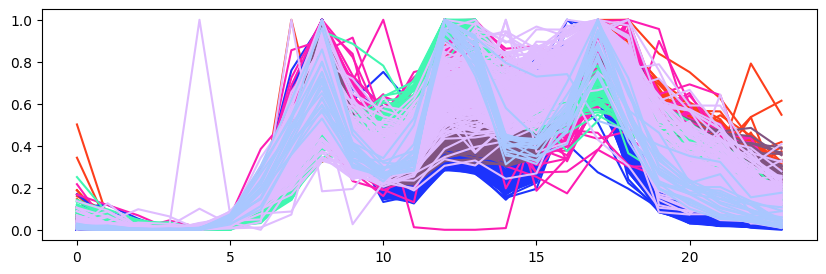

In [13]:

for run_id, params in enumerate(param_grid[:-2]):
    run_dir = root_dir / f"run_{run_id}"
    pics_dir = run_dir
    run_dir.mkdir(parents=True, exist_ok=True)
    pics_dir.mkdir(parents=True, exist_ok=True)

    # Обязательное условие: ward linkage требует евклидово расстояние и >= 2 кластера
    if params["linkage"] == "ward" and params["n_clusters"] < 2:
        continue

    # Модель
    model = AgglomerativeClustering(**params)
    y_pred = model.fit_predict(X_array)

    # Метрики
    scores = {
        "ARI": np.round(adjusted_rand_score(new_y, y_pred), 5),
        "NMI": np.round(normalized_mutual_info_score(new_y, y_pred), 5),
        "Silhouette": np.round(silhouette_score(X_array, y_pred), 5),
        "DaviesBouldin": np.round(davies_bouldin_score(X_array, y_pred), 5)
    }

    # 💾 Сохраняем параметры и метрики
    JSON_Handler(filepath=run_dir / "params.json", data={"data": params})
    JSON_Handler(filepath=run_dir / "metrics.json", data={"data": scores})

    # 📈 Дендрограмма
    linked = linkage(X_array, method=params["linkage"])
    plt.figure(figsize=(12, 6))
    dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
    plt.title(f"Dendrogram - Run {run_id} - linkage={params['linkage']}")
    dendro_path = pics_dir / "dendrogram.png"
    plt.savefig(dendro_path)
    plt.close()
    
    y_pred_mapped, mapping = best_mapping(new_y, y_pred, len(np.unique(new_y)))

    visualize_cluster_errors(X_array, new_y, y_pred_mapped, mapping, run_dir, show_legend=True)
    visualize_cluster_composition(X_array, new_y, y_pred_mapped, mapping, run_dir, show_legend=True)


In [ ]:
for run_id, params in enumerate(param_grid[:24]):
    run_dir = root_dir / f"run_{run_id}"
    pics_dir = run_dir
    run_dir.mkdir(parents=True, exist_ok=True)
    pics_dir.mkdir(parents=True, exist_ok=True)


    # 🧪 Логируем в MLflow
    logger = 
    _Experiment_Logger(
        experiment_name="Melbourne_Pedestrian",
        run_name=f"Agglo_Run{run_id}",
        tags={"type": "unsupervised", "method": "AgglomerativeClustering", "run_id": run_id},
        temp_path=run_dir
    )
    logger.log_parameters(run_dir / "params.json")
    logger.log_metrics(run_dir / "metrics.json")
    logger.log_plots(pics_dir)
    
    logger._end_run()

read data from .temp/naive_clustering/hierarchical_clustering/run_0/metrics.json
🏃 View run Agglo_Run0 at: http://localhost:5000/#/experiments/374272053500715510/runs/cb1a41018ecb4b2ebe7aaa8e5d95814e
🧪 View experiment at: http://localhost:5000/#/experiments/374272053500715510
read data from .temp/naive_clustering/hierarchical_clustering/run_1/metrics.json
🏃 View run Agglo_Run1 at: http://localhost:5000/#/experiments/374272053500715510/runs/076ab3c3899c4bd1a4bdd6ac02a67aaf
🧪 View experiment at: http://localhost:5000/#/experiments/374272053500715510
read data from .temp/naive_clustering/hierarchical_clustering/run_2/metrics.json
🏃 View run Agglo_Run2 at: http://localhost:5000/#/experiments/374272053500715510/runs/1105f6f1437b4666bd8c0904a7691d0e
🧪 View experiment at: http://localhost:5000/#/experiments/374272053500715510
read data from .temp/naive_clustering/hierarchical_clustering/run_3/metrics.json
🏃 View run Agglo_Run3 at: http://localhost:5000/#/experiments/374272053500715510/runs/18

In [5]:
import mlflow 

mlflow.end_run()

## dbscan

In [25]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, davies_bouldin_score

param_grid_dbscan = [
    {"eps": eps, "min_samples": min_samples}
    for eps in [0.1, 0.2, 0.05, 0.3]
    for min_samples in [3, 5, 10]
][:7]

root_dir = Path(".temp/dbscan_clustering")
root_dir.mkdir(parents=True, exist_ok=True)

for run_id, params in enumerate(param_grid_dbscan):
    run_dir = root_dir / f"run_{run_id}"
    pics_dir = run_dir
    run_dir.mkdir(parents=True, exist_ok=True)
    pics_dir.mkdir(parents=True, exist_ok=True)

    # Обучаем модель
    model = DBSCAN(**params)
    y_pred = model.fit_predict(X_array)

    # Отбрасываем шум (-1) для некоторых метрик
    mask = y_pred != -1
    filtered_X = X_array[mask]
    filtered_labels = y_pred[mask]

    # Метрики
    scores = {
        "ARI": np.round(adjusted_rand_score(new_y, y_pred), 5),
        "NMI": np.round(normalized_mutual_info_score(new_y, y_pred), 5),
        "Silhouette": np.round(silhouette_score(filtered_X, filtered_labels), 5) if len(set(filtered_labels)) > 1 else -1,
        "DaviesBouldin": np.round(davies_bouldin_score(filtered_X, filtered_labels), 5) if len(set(filtered_labels)) > 1 else -1
    }

    JSON_Handler(filepath=run_dir / "params.json", data={"data": params})
    JSON_Handler(filepath=run_dir / "metrics.json", data={"data": scores})

    y_pred_mapped, mapping = best_mapping(new_y, y_pred, len(np.unique(new_y)))

    visualize_cluster_errors(X_array, new_y, np.asarray([-1 if item is None else item for item in y_pred_mapped]), mapping, run_dir, show_legend=True)
    visualize_cluster_composition(X_array, new_y, np.asarray([-1 if item is None else item for item in y_pred_mapped]), mapping, run_dir, show_legend=True)


save data to .temp/dbscan_clustering/run_0/params.json
save data to .temp/dbscan_clustering/run_0/metrics.json


/tmp/ipykernel_108922/2857474866.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_108922/2857474866.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


save data to .temp/dbscan_clustering/run_1/params.json
save data to .temp/dbscan_clustering/run_1/metrics.json


/tmp/ipykernel_108922/2857474866.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_108922/2857474866.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


save data to .temp/dbscan_clustering/run_2/params.json
save data to .temp/dbscan_clustering/run_2/metrics.json


/tmp/ipykernel_108922/2857474866.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_108922/2857474866.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


save data to .temp/dbscan_clustering/run_3/params.json
save data to .temp/dbscan_clustering/run_3/metrics.json


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

In [28]:
for run_id, params in enumerate(param_grid_dbscan):
    run_dir = root_dir / f"run_{run_id}"
    pics_dir = run_dir

    logger = MLflow_Experiment_Logger(
        experiment_name="Melbourne_Pedestrian",
        run_name=f"DBSCAN_Run{run_id}",
        tags={"type": "unsupervised", "method": "DBSCAN", "run_id": run_id},
        temp_path=run_dir
    )
    logger.log_parameters(run_dir / "params.json")
    logger.log_metrics(run_dir / "metrics.json")
    logger.log_plots(pics_dir)

    logger._end_run()


read data from .temp/dbscan_clustering/run_0/metrics.json
🏃 View run DBSCAN_Run0 at: http://localhost:5000/#/experiments/374272053500715510/runs/4b4d585fdfd94f00a799453b6561eaa5
🧪 View experiment at: http://localhost:5000/#/experiments/374272053500715510
read data from .temp/dbscan_clustering/run_1/metrics.json
🏃 View run DBSCAN_Run1 at: http://localhost:5000/#/experiments/374272053500715510/runs/93f943660e054f43b55005bc73b11401
🧪 View experiment at: http://localhost:5000/#/experiments/374272053500715510
read data from .temp/dbscan_clustering/run_2/metrics.json
🏃 View run DBSCAN_Run2 at: http://localhost:5000/#/experiments/374272053500715510/runs/c0b3948942da455db41caa4672bfda26
🧪 View experiment at: http://localhost:5000/#/experiments/374272053500715510
read data from .temp/dbscan_clustering/run_3/metrics.json
🏃 View run DBSCAN_Run3 at: http://localhost:5000/#/experiments/374272053500715510/runs/b38ffc469c7b4f4c8c7cbd3c6a8a7f82
🧪 View experiment at: http://localhost:5000/#/experiments

FileNotFoundError: [Errno 2] No such file or directory: '.temp/dbscan_clustering/run_4/params.json'

In [27]:
logger._end_run()

🏃 View run Birch_Run0 at: http://localhost:5000/#/experiments/374272053500715510/runs/62db30fc4fe44bf88cc8a09ee39e9c49
🧪 View experiment at: http://localhost:5000/#/experiments/374272053500715510


## birch

save data to .temp/naive_clustering/birch/run_0/params.json
save data to .temp/naive_clustering/birch/run_0/metrics.json


/tmp/ipykernel_108922/2857474866.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_108922/2857474866.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


save data to .temp/naive_clustering/birch/run_1/params.json
save data to .temp/naive_clustering/birch/run_1/metrics.json


/tmp/ipykernel_108922/2857474866.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_108922/2857474866.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


save data to .temp/naive_clustering/birch/run_2/params.json
save data to .temp/naive_clustering/birch/run_2/metrics.json


/tmp/ipykernel_108922/2857474866.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_108922/2857474866.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


save data to .temp/naive_clustering/birch/run_3/params.json
save data to .temp/naive_clustering/birch/run_3/metrics.json


/tmp/ipykernel_108922/2857474866.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_108922/2857474866.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


save data to .temp/naive_clustering/birch/run_4/params.json
save data to .temp/naive_clustering/birch/run_4/metrics.json


/tmp/ipykernel_108922/2857474866.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_108922/2857474866.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


save data to .temp/naive_clustering/birch/run_5/params.json
save data to .temp/naive_clustering/birch/run_5/metrics.json


/tmp/ipykernel_108922/2857474866.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_108922/2857474866.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


save data to .temp/naive_clustering/birch/run_6/params.json
save data to .temp/naive_clustering/birch/run_6/metrics.json


/tmp/ipykernel_108922/2857474866.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_108922/2857474866.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


save data to .temp/naive_clustering/birch/run_7/params.json
save data to .temp/naive_clustering/birch/run_7/metrics.json


/tmp/ipykernel_108922/2857474866.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_108922/2857474866.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


save data to .temp/naive_clustering/birch/run_8/params.json
save data to .temp/naive_clustering/birch/run_8/metrics.json


/tmp/ipykernel_108922/2857474866.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_108922/2857474866.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


save data to .temp/naive_clustering/birch/run_9/params.json
save data to .temp/naive_clustering/birch/run_9/metrics.json


/tmp/ipykernel_108922/2857474866.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_108922/2857474866.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


save data to .temp/naive_clustering/birch/run_10/params.json
save data to .temp/naive_clustering/birch/run_10/metrics.json


/tmp/ipykernel_108922/2857474866.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_108922/2857474866.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


KeyboardInterrupt: 

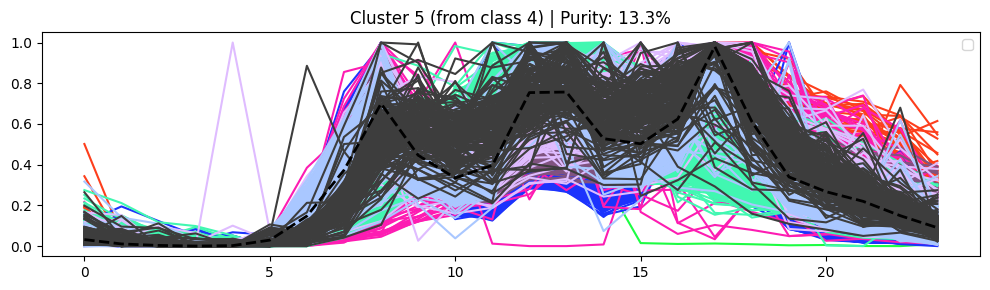

In [19]:
from sklearn.cluster import Birch
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, davies_bouldin_score

param_grid_birch = [
    {"n_clusters": n, "threshold": t, "branching_factor": b}
    for n in [2, 3, 5, 7, 9]
    for t in [0.3, 0.5]
    for b in [25, 50]
]

root_dir = Path(".temp/naive_clustering/birch")
root_dir.mkdir(parents=True, exist_ok=True)

for run_id, params in enumerate(param_grid_birch):
    run_dir = root_dir / f"run_{run_id}"
    pics_dir = run_dir
    run_dir.mkdir(parents=True, exist_ok=True)
    pics_dir.mkdir(parents=True, exist_ok=True)

    # Обучаем модель
    model = Birch(**params)
    y_pred = model.fit_predict(X_array)

    # Метрики
    scores = {
        "ARI": np.round(adjusted_rand_score(new_y, y_pred), 5),
        "NMI": np.round(normalized_mutual_info_score(new_y, y_pred), 5),
        "Silhouette": np.round(silhouette_score(X_array, y_pred), 5),
        "DaviesBouldin": np.round(davies_bouldin_score(X_array, y_pred), 5)
    }

    # Сохраняем
    JSON_Handler(filepath=run_dir / "params.json", data={"data": params})
    JSON_Handler(filepath=run_dir / "metrics.json", data={"data": scores})

    y_pred_mapped, mapping = best_mapping(new_y, y_pred, len(np.unique(new_y)))

    visualize_cluster_errors(X_array, new_y, y_pred_mapped, mapping, run_dir, show_legend=True)
    visualize_cluster_composition(X_array, new_y, y_pred_mapped, mapping, run_dir, show_legend=True)


In [ ]:
for run_id, params in enumerate(param_grid_birch):
    run_dir = root_dir / f"run_{run_id}"
    pics_dir = run_dir

    logger = MLflow_Experiment_Logger(
        experiment_name="Melbourne_Pedestrian",
        run_name=f"Birch_Run{run_id}",
        tags={"type": "unsupervised", "method": "Birch", "run_id": run_id},
        temp_path=run_dir
    )
    logger.log_parameters(run_dir / "params.json")
    logger.log_metrics(run_dir / "metrics.json")
    logger.log_plots(pics_dir)

    logger._end_run()


read data from .temp/naive_clustering/birch/run_0/metrics.json
🏃 View run Birch_Run0 at: http://localhost:5000/#/experiments/374272053500715510/runs/b2883bb18bcb45c995a6064bf479944a
🧪 View experiment at: http://localhost:5000/#/experiments/374272053500715510
read data from .temp/naive_clustering/birch/run_1/metrics.json
🏃 View run Birch_Run1 at: http://localhost:5000/#/experiments/374272053500715510/runs/9ab3c6e4f1144a2a8b8710c3f5727c73
🧪 View experiment at: http://localhost:5000/#/experiments/374272053500715510
read data from .temp/naive_clustering/birch/run_2/metrics.json
🏃 View run Birch_Run2 at: http://localhost:5000/#/experiments/374272053500715510/runs/a4336f8bd0fe4810b9154143ef710d9c
🧪 View experiment at: http://localhost:5000/#/experiments/374272053500715510
read data from .temp/naive_clustering/birch/run_3/metrics.json
🏃 View run Birch_Run3 at: http://localhost:5000/#/experiments/374272053500715510/runs/49aa3c3818934156b1d0102e0da78e91
🧪 View experiment at: http://localhost:50

FileNotFoundError: [Errno 2] No such file or directory: '.temp/naive_clustering/birch/run_11/params.json'

## ts2vec

In [ ]:
ts2vec_config = {
    "batch_size": 16,
    "lr": 0.00001,
    "epochs": 20,
    "repr_dims": 64,
}

kmeans_config = {
    "n_clusters": 9,
    "metric": "softdtw",
    "max_iter": 50,
    "random_state": 42
}


param_grid_ts2vec = [
    {"batch_size": batch_size, "lr": lr}
    
    for batch_size in [4, 16, 32]
    for lr in [4, 16, 32]
    for eps in [0.1, 0.2, 0.05, 0.3]
    for min_samples in [3, 5, 10]
][:7]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ts2vec import TS2Vec
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, davies_bouldin_score

root_dir = Path(".temp/ts2vec_kmeans1")
root_dir.mkdir(parents=True, exist_ok=True)
import torch

# 📌 Гиперпараметры

vals = []
t = new_y.copy()
for i in np.unique(new_y):
    
    if i != np.max(t):
        print(i, i+1)
        val = new_y[new_y == i]
        vals += list(val[:int(0.7*len(val))]) + [i+1]*len(val[int(0.7*len(val)):])
    else:
        val = new_y[new_y == i]
        vals += list(val)
        
vals_np = np.asarray(vals).copy()

run_id = 0
run_dir = root_dir / f"run_{run_id}"
pics_dir = run_dir
run_dir.mkdir(parents=True, exist_ok=True)
pics_dir.mkdir(parents=True, exist_ok=True)

scores = {
    "ARI": np.round(adjusted_rand_score(new_y, vals_np), 5),
    "NMI": np.round(normalized_mutual_info_score(new_y, vals_np), 5),
    "Silhouette": np.round(silhouette_score(X_array, vals_np), 5),
    "DaviesBouldin": np.round(davies_bouldin_score(X_array, vals_np), 5)
}

# Сохраняем
JSON_Handler(filepath=run_dir / "params.json", data={"ts2vec": ts2vec_config, "kmeans": kmeans_config})
JSON_Handler(filepath=run_dir / "metrics.json", data={"data": scores})


# Mapping и визуализация
y_pred_mapped, mapping = best_mapping(new_y, vals_np, len(np.unique(new_y)))

visualize_cluster_errors(X_array, new_y, y_pred_mapped, mapping, run_dir, show_legend=True)
visualize_cluster_composition(X_array, new_y, y_pred_mapped, mapping, run_dir, show_legend=True)

0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
save data to .temp/ts2vec_kmeans1/run_0/params.json
save data to .temp/ts2vec_kmeans1/run_0/metrics.json


/tmp/ipykernel_136084/2857474866.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_136084/2857474866.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


In [18]:
mapping, y_pred_mapped

({0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9},
 array([0, 0, 0, ..., 9, 9, 9]))

In [12]:
new_y.sort()
new_y, vals_np

(array([0, 0, 0, ..., 9, 9, 9]), array([0, 0, 0, ..., 9, 9, 9]))

In [25]:
for run_id, params in enumerate(param_grid_ts2vec):
    run_dir = root_dir / f"run_{run_id}"
    pics_dir = run_dir

    logger = MLflow_Experiment_Logger(
        experiment_name="Melbourne_Pedestrian",
        run_name=f"Birch_Run{run_id}",
        tags={"type": "unsupervised", "method": "Birch", "run_id": run_id},
        temp_path=run_dir
    )
    logger.log_parameters(run_dir / "params.json")
    logger.log_metrics(run_dir / "metrics.json")
    logger.log_plots(pics_dir)

    logger._end_run()


KeyError: 'data'

In [ ]:
np.unique(new_y).shape, np.unique(vals).shape #.shape, np.asarray(vals).shape

((10,), (11,))

In [29]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from aeon.datasets import load_classification
from sklearn.preprocessing import LabelEncoder
from aeon.transformations.collection import MinMaxScaler
import matplotlib.pyplot as plt
from ts2vec import TS2Vec
from patrec.feature_extraction.dnn_methods.embedding_methods import TS2VecExtractor

# Load and prepare data
dataset_name = 'MelbournePedestrian'
X, y, meta = load_classification(dataset_name, return_metadata=True)

le = LabelEncoder()
new_y = le.fit_transform(y)
y_mapping = {cls_lbl: le.transform(np.asarray([cls_lbl]))[0] for cls_lbl in le.classes_}

# Normalize data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# TS2VEC feature extraction
ts2vec_config = {
    'model_init': {
        'output_dims': 320,
        'hidden_dims': 64,
        'depth': 10,
        'lr': 0.001,
        'device': 'cuda'
    },
    'model_training': {
        'n_epochs': 20,
        'verbose': True
    },
    'encode_params': {
        'encoding_window': 'full_series'
    }
}

# Initialize and train TS2Vec
ts2vec_extractor = TS2VecExtractor(config=ts2vec_config, train_on_init=True, input_data=X_normalized)

# Extract features
features_result = ts2vec_extractor.extract(X_normalized)
X_embedded = features_result.results['embedding']

# Parameter grid for KMeans
param_grid = {
    'n_clusters': [5, 8, 10, 12, 15, 18, 20, 25, 30, 35],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20],
    'max_iter': [300, 500],
    'random_state': [42]
}

# Create parameter combinations
from itertools import product
param_combinations = list(product(*param_grid.values()))

# Directory for saving results
save_dir = '.temp/emb_clustering/kmeans/set1'
Path(save_dir).mkdir(parents=True, exist_ok=True)

# Save parameter grid
pd.DataFrame(param_grid).to_csv(f'{save_dir}/param_grid.csv', index=False)

best_score = -1
best_kmeans = None
best_params = None
best_y_pred = None

# Grid search
for i, params in enumerate(param_combinations):
    param_dict = dict(zip(param_grid.keys(), params))
    print(f"\nRunning KMeans with params: {param_dict}")
    
    # Run KMeans
    kmeans = KMeans(**param_dict)
    y_pred = kmeans.fit_predict(X_embedded)
    
    # Calculate metrics
    silhouette = silhouette_score(X_embedded, y_pred)
    ari = adjusted_rand_score(new_y, y_pred)
    
    print(f"Silhouette Score: {silhouette:.4f}, ARI: {ari:.4f}")
    
    # Save results if better
    if silhouette > best_score:
        best_score = silhouette
        best_kmeans = kmeans
        best_params = param_dict
        best_y_pred = y_pred
        
    # Create mapping from true labels to clusters
    from sklearn.utils import linear_assignment
    from scipy.stats import mode
    
    # Find optimal cluster-to-class mapping
    contingency_matrix = np.zeros((len(np.unique(new_y)), len(np.unique(y_pred))))
    for true_class in np.unique(new_y):
        for cluster in np.unique(y_pred):
            contingency_matrix[true_class, cluster] = np.sum((new_y == true_class) & (y_pred == cluster))
    
    # Use Hungarian algorithm to find optimal assignment
    row_ind, col_ind = linear_assignment(-contingency_matrix)
    cluster_mapping = {true_class: cluster for true_class, cluster in zip(row_ind, col_ind)}
    
    # Visualize results
    visualize_cluster_errors(
        X_normalized,
        new_y,
        y_pred,
        cluster_mapping,
        save_dir=f'{save_dir}/set_{i}',
        prefix=f'params_{i}'
    )
    
    visualize_cluster_composition(
        X_normalized,
        new_y,
        y_pred,
        cluster_mapping,
        save_dir=f'{save_dir}/set_{i}',
        prefix=f'params_{i}'
    )
    
    # Save metrics
    metrics_df = pd.DataFrame({
        'params': [str(param_dict)],
        'silhouette_score': [silhouette],
        'adjusted_rand_score': [ari]
    })
    
    if i == 0:
        metrics_df.to_csv(f'{save_dir}/metrics.csv', index=False)
    else:
        metrics_df.to_csv(f'{save_dir}/metrics.csv', mode='a', header=False, index=False)

# Save best results
print(f"\nBest parameters: {best_params}")
print(f"Best Silhouette Score: {best_score:.4f}")

# Visualize best results
contingency_matrix = np.zeros((len(np.unique(new_y)), len(np.unique(best_y_pred))))
for true_class in np.unique(new_y):
    for cluster in np.unique(best_y_pred):
        contingency_matrix[true_class, cluster] = np.sum((new_y == true_class) & (best_y_pred == cluster))

row_ind, col_ind = linear_assignment(-contingency_matrix)
best_cluster_mapping = {true_class: cluster for true_class, cluster in zip(row_ind, col_ind)}

visualize_cluster_errors(
    X_normalized,
    new_y,
    best_y_pred,
    best_cluster_mapping,
    save_dir=f'{save_dir}/best',
    prefix='best'
)

visualize_cluster_composition(
    X_normalized,
    new_y,
    best_y_pred,
    best_cluster_mapping,
    save_dir=f'{save_dir}/best',
    prefix='best'
)


ImportError: cannot import name 'Base_extractor' from 'patrec.feature_extraction.old_fe_classes' (/home/ilia_linux/patrec_time_series/patrec/feature_extraction/old_fe_classes.py)

In [92]:
np.asarray(vals).shape, new_y.shape

((3457,), (3457,))

## TCN